Step 1: Loading Data...
Classes: ["Alzheimer's Disease" 'Frontotemporal Dementia' 'Lewy Body Dementia'
 "Parkinson's Disease" 'Vascular Dementia']
Step 2: Extracting LDA Features...
LDA Feature Matrix Shape: (1312, 20)

--- LDA Topics Preview (Top 5 Words) ---
Topic 1: sleep, year, woman, age, regression
Topic 2: disease, patient, body, brain, motor
Topic 3: blood, brain, barrier, bbb, contrast
Topic 4: inf, ci, mg, year, confidence
Topic 5: cortex, frontal, region, cortical, binding

Step 3: Training XGBoost...
Running 10-Fold Cross-Validation...
Mean CV Accuracy: 0.3910
Standard Deviation: 0.0258

Step 4: Plotting Learning Curves...


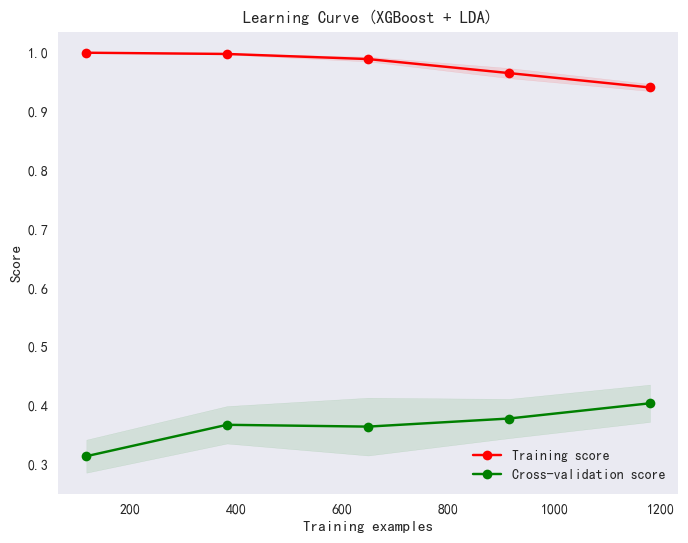


--- Classification Report ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.35      0.43      0.38        68
Frontotemporal Dementia       0.57      0.51      0.54        59
     Lewy Body Dementia       0.53      0.42      0.47        64
    Parkinson's Disease       0.39      0.38      0.39        68
      Vascular Dementia       0.46      0.50      0.48        70

               accuracy                           0.45       329
              macro avg       0.46      0.45      0.45       329
           weighted avg       0.46      0.45      0.45       329



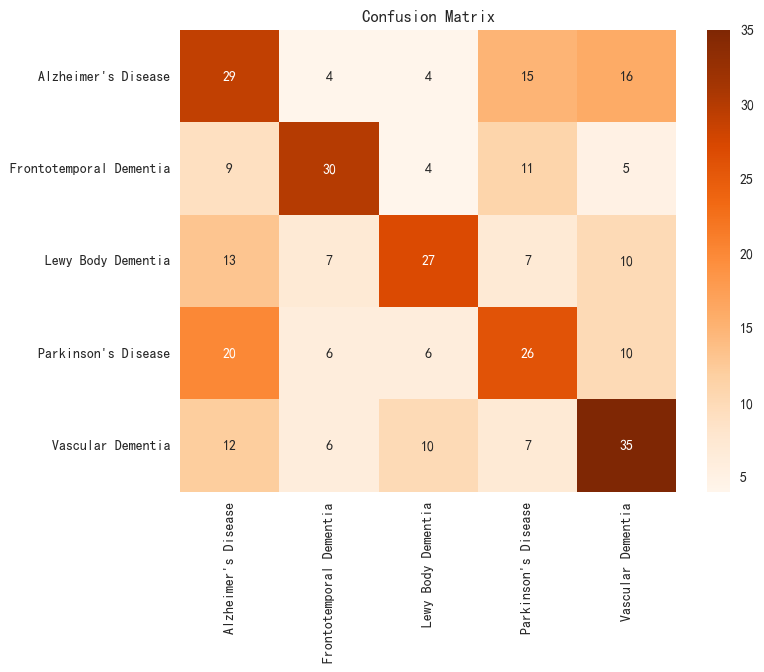

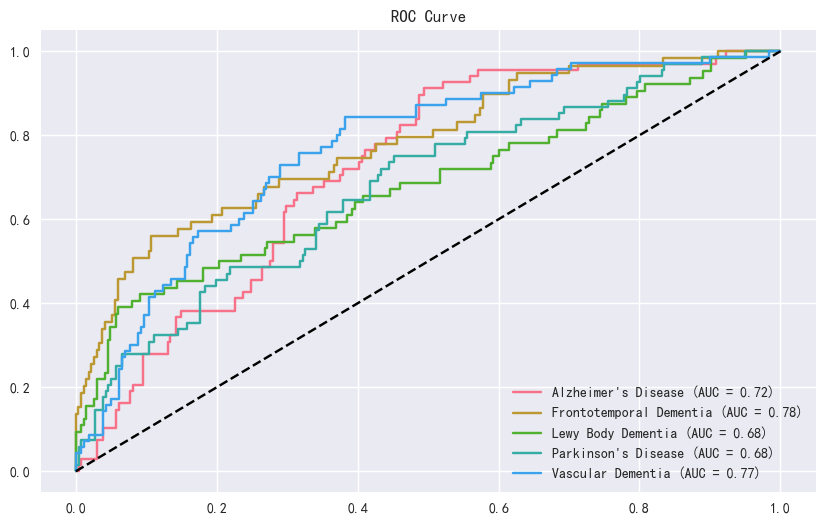


Step 6: Error Analysis...
Top Words in Errors: [('disease', np.int64(694)), ('patient', np.int64(111)), ('study', np.int64(100)), ('brain', np.int64(69)), ('cognitive', np.int64(66)), ('group', np.int64(58)), ('protein', np.int64(56)), ('result', np.int64(56)), ('function', np.int64(48)), ('symptom', np.int64(48)), ('clinical', np.int64(46)), ('method', np.int64(46)), ('model', np.int64(46)), ('neurodegenerative', np.int64(46)), ('using', np.int64(40)), ('control', np.int64(39)), ('associated', np.int64(38)), ('related', np.int64(36)), ('level', np.int64(35)), ('synuclein', np.int64(30))]
--- Failure Example ---
True: Parkinson's Disease | Pred: Frontotemporal Dementia
Text: manuscript examines complex connection among heavy metal toxicity protein misfolding neurodegenerati...

Step 7: SHAP Analysis (Topic Contribution)...
SHAP Summary for Class: Alzheimer's Disease


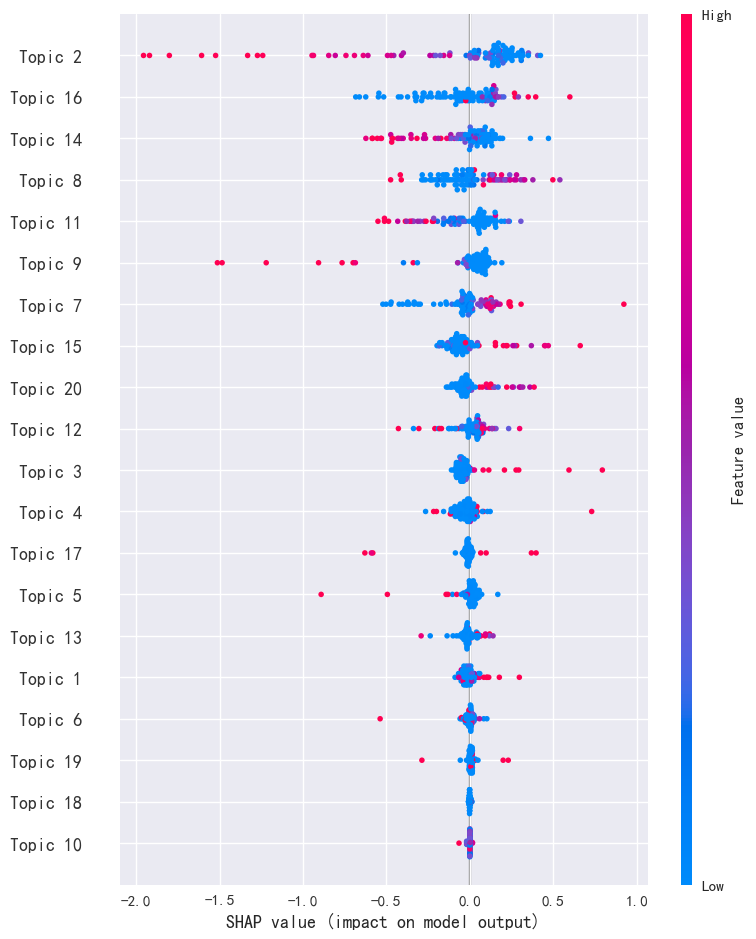

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import shap
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 数据加载与预处理 (Data Loading & Preprocessing)
# ==========================================
print("Step 1: Loading Data...")
try:
    df = pd.read_csv('../cleaned_data.csv')
except FileNotFoundError:
    df = pd.read_csv('cleaned_data.csv')

df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

# 标签编码 (XGBoost 必须使用 0-N 整数)
le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])
label_names = le.classes_
print(f"Classes: {label_names}")

# 划分训练集和测试集
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label_Encoded'], 
    test_size=0.2, random_state=42, stratify=df['Label_Encoded']
)

# ==========================================
# 2. 特征工程: LDA (Feature Engineering)
# ==========================================
print("Step 2: Extracting LDA Features...")
# 2.1 词频向量化
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf_train = tf_vectorizer.fit_transform(X_train_raw)
tf_test = tf_vectorizer.transform(X_test_raw)

# 2.2 LDA 模型训练
n_topics = 20
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=42, n_jobs=-1)
X_train_features = lda.fit_transform(tf_train)
X_test_features = lda.transform(tf_test)

feature_names_lda = [f"Topic {i+1}" for i in range(n_topics)]
print(f"LDA Feature Matrix Shape: {X_train_features.shape}")

tf_feature_names = tf_vectorizer.get_feature_names_out()
print("\n--- LDA Topics Preview (Top 5 Words) ---")
for topic_idx, topic in enumerate(lda.components_[:5]):
    top_words = [tf_feature_names[i] for i in topic.argsort()[:-6:-1]]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

# ==========================================
# 3. 模型训练: XGBoost (Training)
# ==========================================
print("\nStep 3: Training XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

# 10-Fold CV
print("Running 10-Fold Cross-Validation...")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_train_features, y_train, cv=cv, scoring='accuracy')

print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Train Full Model
xgb_model.fit(X_train_features, y_train)

# ==========================================
# 4. 学习曲线 (Bias vs Variance)
# ==========================================
print("\nStep 4: Plotting Learning Curves...")
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(xgb_model, "Learning Curve (XGBoost + LDA)", X_train_features, y_train, cv=cv, n_jobs=-1)

# ==========================================
# 5. 评估与可视化 (Evaluation)
# ==========================================
y_pred = xgb_model.predict(X_test_features)
y_prob = xgb_model.predict_proba(X_test_features)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=label_names))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 6))
y_test_bin = pd.get_dummies(y_test).values
if y_test_bin.shape[1] == len(label_names):
    for i, class_label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# ==========================================
# 6. 误差分析 (Error Analysis)
# ==========================================
print("\nStep 6: Error Analysis...")
misclassified_indices = np.where(y_test != y_pred)[0]
if len(misclassified_indices) > 0:
    error_docs = X_test_raw.iloc[misclassified_indices]
    error_cv = CountVectorizer(stop_words='english', max_features=20)
    try:
        error_counts = error_cv.fit_transform(error_docs)
        error_words = error_cv.get_feature_names_out()
        error_word_freq = np.asarray(error_counts.sum(axis=0)).flatten()
        print(f"Top Words in Errors: {sorted(dict(zip(error_words, error_word_freq)).items(), key=lambda x: x[1], reverse=True)}")
    except: pass
    
    print("--- Failure Example ---")
    if len(misclassified_indices) > 0:
        idx = misclassified_indices[0]
        print(f"True: {label_names[y_test.iloc[idx]]} | Pred: {label_names[y_pred[idx]]}")
        print(f"Text: {X_test_raw.iloc[idx][:100]}...")

# ==========================================
# 7. 可解释性 SHAP (Explainability)
# ==========================================
print("\nStep 7: SHAP Analysis (Topic Contribution)...")
try:
    explainer = shap.TreeExplainer(xgb_model)
    sample_size = min(100, X_test_features.shape[0])
    X_shap_sample = X_test_features[:sample_size]
    shap_values = explainer.shap_values(X_shap_sample)
    
    target_idx = 0
    if isinstance(shap_values, list):
         sv = shap_values[target_idx]
    else:
        if len(np.array(shap_values).shape) == 3:
             sv = shap_values[:, :, target_idx]
        else:
             sv = shap_values

    print(f"SHAP Summary for Class: {label_names[target_idx]}")
    shap.summary_plot(sv, X_shap_sample, feature_names=feature_names_lda, show=False)
    plt.show()
except Exception as e:
    print(f"SHAP skipped: {e}")